# Feature Extraction using Iterated Sums Signatures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from context import fruits
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use(['dark_background'])

np.random.seed(1234)

## Create random time series data
We will generate $m$ time series (in $\mathbb{R}^n$).

In [2]:
# define two model functions for two different classes
def f(x):
    return 2/3*np.sin(2*x+0.12)+1/4*np.sin(4*x+0.5)+8/9*np.sin(0.8*x+4)
def g(x):
    return 2/5*np.sin(3*x+0.12)+1/4*np.sin(1/2*x)+np.sin(3/2*x+4)

In [3]:
class_1_instances = 50
class_2_instances = 50
x_range_limit = n = 100
num_classes = 2

m = class_1_instances+class_2_instances
x_range = np.linspace(0, 2*np.pi, num=x_range_limit)
model_1 = np.vectorize(f)(x_range)
model_2 = np.vectorize(g)(x_range)
X = np.zeros((m, x_range_limit))
y = np.zeros(m)
for i in range(class_1_instances):
    X[i,:] = model_1 + np.random.normal(loc=0, scale=0.1, size=x_range_limit)
for i in range(class_2_instances):
    X[class_1_instances+i,:] = model_2 + np.random.normal(loc=0, scale=0.1, size=x_range_limit)
    y[class_1_instances+i] = 1
print(f"Shape of X: {X.shape}")

Shape of X: (100, 100)


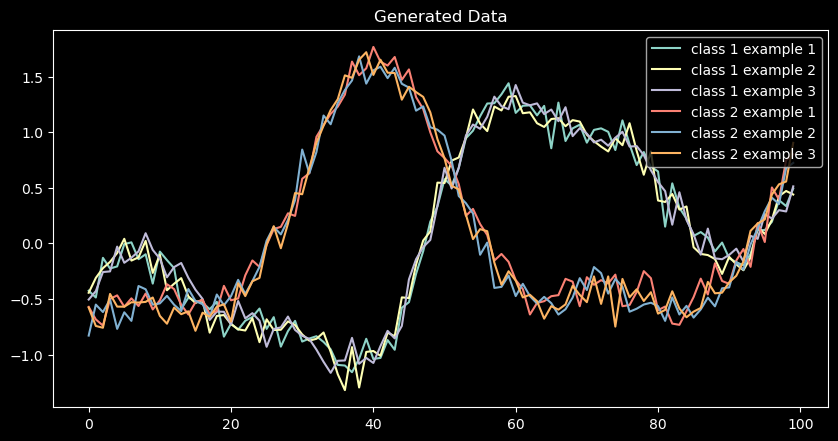

In [4]:
fig, ax = plt.subplots()
ax.set_title("Generated Data")
examples_per_class = 3
for i in range(num_classes):
    for j in range(examples_per_class):
        ax.plot(X[y==i][j], label=f"class {i+1} example {j+1}")
ax.legend(loc="upper right")
plt.show()

## 0) Initialize FeatureExtractor

In [5]:
featex = fruits.FeatureExtractor()
# data will be reshaped to (100, 1, 100)
featex.set_input_data(X)

## 1) Specify DataPreperateur

In [6]:
featex.set_data_preparateur(fruits.preparateurs.INC)
X_inc = featex.prepared_data()

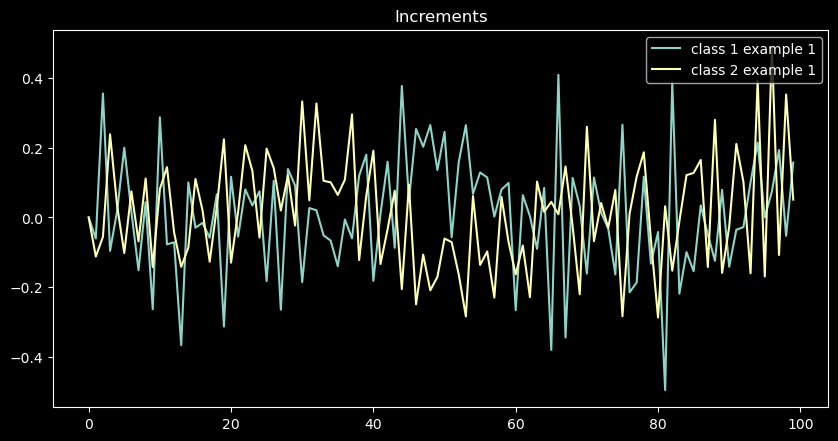

In [7]:
fig, ax = plt.subplots()
ax.set_title("Increments")
examples_per_class = 1
for i in range(num_classes):
    for j in range(examples_per_class):
        ax.plot(X_inc[y==i][j, 0], label=f"class {i+1} example {j+1}")
ax.legend(loc="upper right")
plt.show()

## 2) Generate Concatenations and calculate Iterated Sums

In [8]:
num_concatenations = 10
concatenations = [fruits.SummationIterator.build_from_concatenationstring("[1]"),
                  fruits.SummationIterator.build_from_concatenationstring("[1][1]"),
                  fruits.SummationIterator.build_from_concatenationstring("[1][11]"),
                  fruits.SummationIterator.build_from_concatenationstring("[11][1]"),
                  fruits.SummationIterator.build_from_concatenationstring("[1][111]"),
                  fruits.SummationIterator.build_from_concatenationstring("[111][1]"),
                  fruits.SummationIterator.build_from_concatenationstring("[111][11]"),
                  fruits.SummationIterator.build_from_concatenationstring("[11][111]"),
                  fruits.SummationIterator.build_from_concatenationstring("[1][11][111]"),
                  fruits.SummationIterator.build_from_concatenationstring("[11][1][111]")]

# uncomment for random concatenations
# concatenations = fruits.iterators.generate_random_concatenations(num_concatenations, dim=1,\
#                                              max_letter_weight=4, max_concatenation_length=8)

print("\n".join(map(str,concatenations)))

[1]
[1][1]
[1][11]
[11][1]
[1][111]
[111][1]
[111][11]
[11][111]
[1][11][111]
[11][1][111]


In [9]:
for conc in concatenations:
    featex.add_summation_iterator(conc)

In [10]:
# iterated sums will be calculated on prepared data
X_iter = featex.iterated_sums()
X_iter.shape

(100, 10, 100)

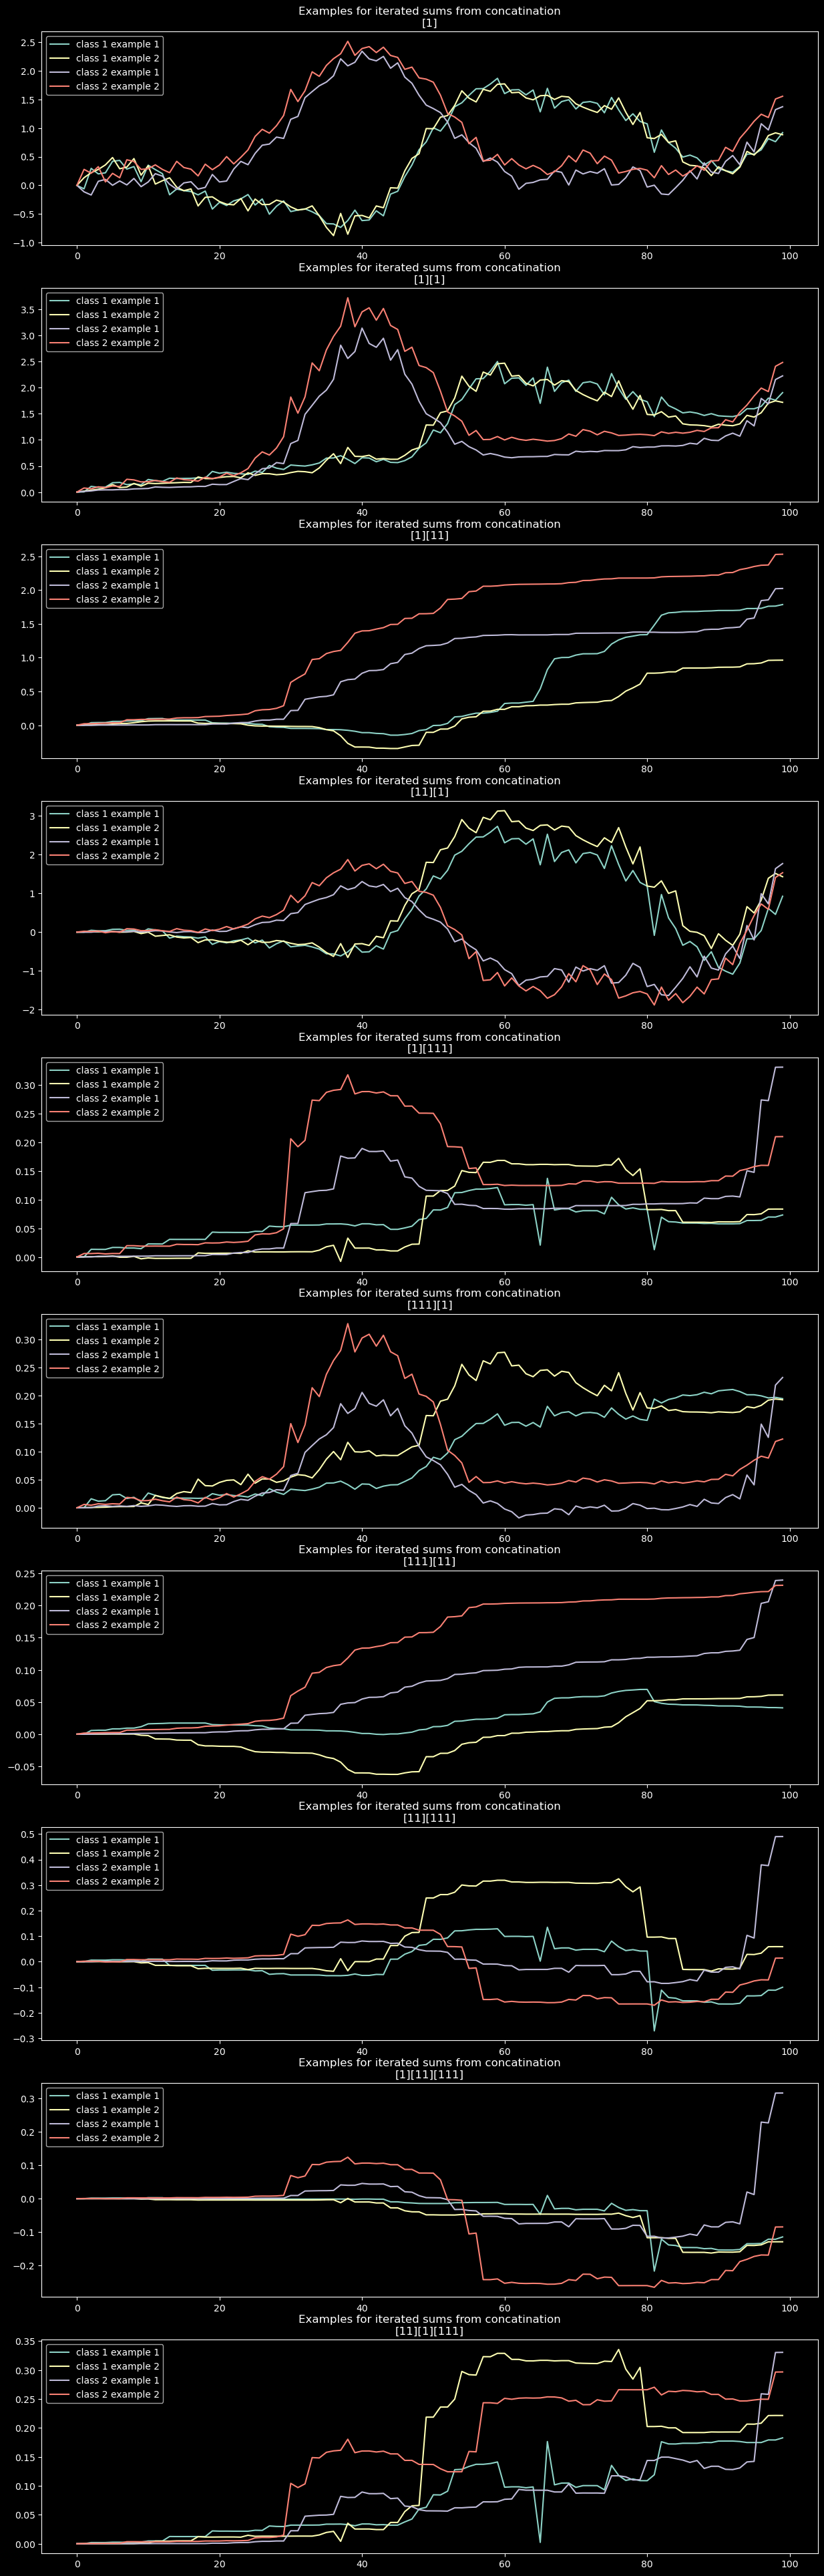

In [11]:
fig, axs = plt.subplots(num_concatenations, 1, figsize=(15, 5*num_concatenations))
examples_per_class = 2
for k in range(num_concatenations):
    for i in range(num_classes):
        for j in range(examples_per_class):
            axs[k].set_title(f"Examples for iterated sums from concatination\n{concatenations[k]}")
            axs[k].plot(X_iter[y==i][j, k], label=f"class {i+1} example {j+1}")
    axs[k].legend(loc="upper left")
plt.show()

## 3) Calculate Features

In [12]:
# Warning: I think ppv is still deprecated, median will not be calculated resp. to each class
feature_functions = [fruits.features.PPV,
                     fruits.features.MAX,
                     fruits.features.MIN]
for ff in feature_functions:
    featex.add_feature(ff)

In [13]:
X_feat = featex.features()
X_feat = X_feat.reshape(m, num_concatenations, len(feature_functions))

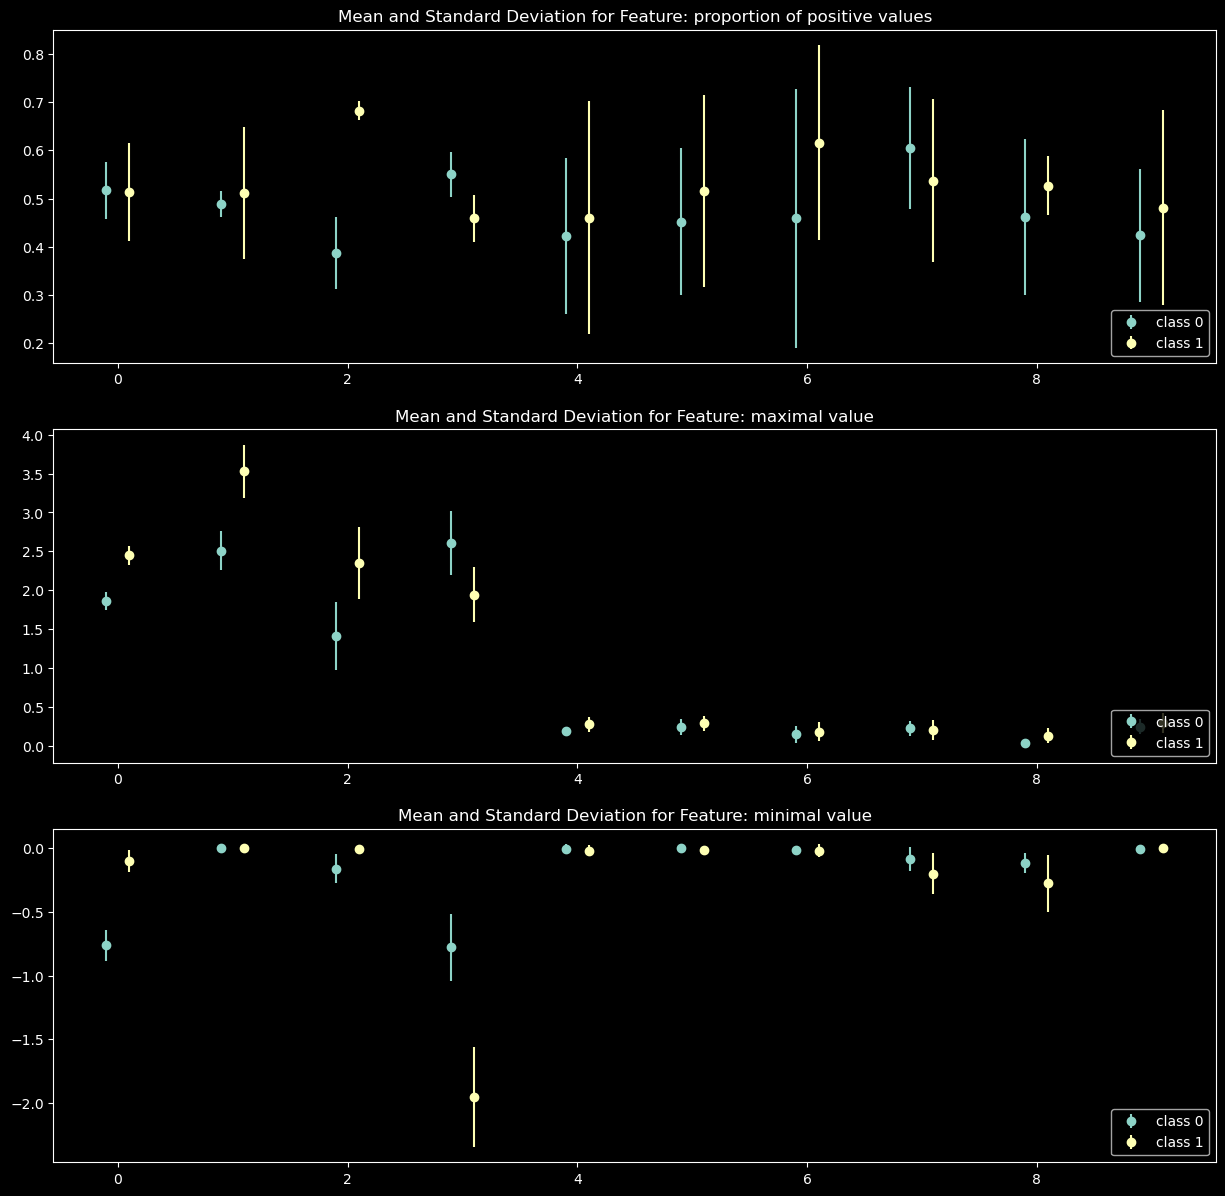

In [14]:
fig, axs = plt.subplots(len(feature_functions), 1, figsize=(15, 5*len(feature_functions)))
x_range = np.arange(num_concatenations)
x_placement = np.linspace(-0.05*num_classes, 0.05*num_classes, num_classes)
for k in range(len(feature_functions)):
    for i in range(num_classes):
        axs[k].errorbar(x_range+x_placement[i], np.mean(X_feat[y==i][:,:,k], axis=0), 
                        yerr=np.zeros(num_concatenations)+np.std(X_feat[y==i][:,:,k], axis=0), fmt="o",
                        label=f"class {i}")
    axs[k].set_title(f"Mean and Standard Deviation for {feature_functions[k]}")
    axs[k].legend(loc="lower right")
plt.show()